# Explore flight delay data

This notebook replicates the month-delay relationship from NB1 while using general functions.

All categorical variables to predict delay time:
1. Month
2. Day of week 
3. Airline
4. Flight number 
5. Tail number
6. Origin airport 
7. Destination airport
8. scheduled departure hour
9. scheduled arrival hour

Continuous variables to predict delay time:
1. scheduled duration
2. distance


Delay time could be
* Calculate extra in-plane delay (ARRIVAL_DELAY - DEPARTURE_DELAY)
    * From this we could see which airlines speed up the most to make up for lost time
    * Maybe should account for delay by TAXI_OUT time
* Arrival_delay could be an extension in TAXI_IN, TAI_OUT, or AIR_TIME?
    * Reference based on the average TAXI_IN and TAXI_OUT time

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

In [2]:
import util

In [3]:
import imp
imp.reload(util)

<module 'util' from '/gh/flightdelay/nbsc/util.py'>

# Load data

In [4]:
df_SAN = util.load_data_SAN()

/Users/scott/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
print(len(df_SAN))
df_SAN.head()

69794


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
477,477,2015,1,1,4,DL,978,N693DL,SAN,SLC,...,906.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
500,500,2015,1,1,4,OO,5608,N930SW,SAN,LAX,...,702.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
517,517,2015,1,1,4,WN,823,N7707C,SAN,BWI,...,1352.0,-23.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
518,518,2015,1,1,4,WN,603,N461WN,SAN,MDW,...,1201.0,-29.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
520,520,2015,1,1,4,UA,1192,N69804,SAN,DEN,...,936.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df_SAN.keys())

Index(['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')


In [12]:
# Add departure hour as a feature
departure_hour = np.floor(df_SAN['SCHEDULED_DEPARTURE'].values/100).astype(int)
arrival_hour = np.floor(df_SAN['SCHEDULED_ARRIVAL'].values/100).astype(int)

df_SAN['HOUR_DEPARTURE'] = departure_hour
df_SAN['HOUR_ARRIVAL'] = arrival_hour


In [14]:
df_SAN.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,HOUR_DEPARTURE,HOUR_ARRIVAL
477,477,2015,1,1,4,DL,978,N693DL,SAN,SLC,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,9
500,500,2015,1,1,4,OO,5608,N930SW,SAN,LAX,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,7
517,517,2015,1,1,4,WN,823,N7707C,SAN,BWI,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,14
518,518,2015,1,1,4,WN,603,N461WN,SAN,MDW,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,12
520,520,2015,1,1,4,UA,1192,N69804,SAN,DEN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,6,9


# Relate departure hour to delays

### Which airlines are which codes?

In [15]:
key_predict = 'DEPARTURE_DELAY'
key_feature = 'HOUR_DEPARTURE'

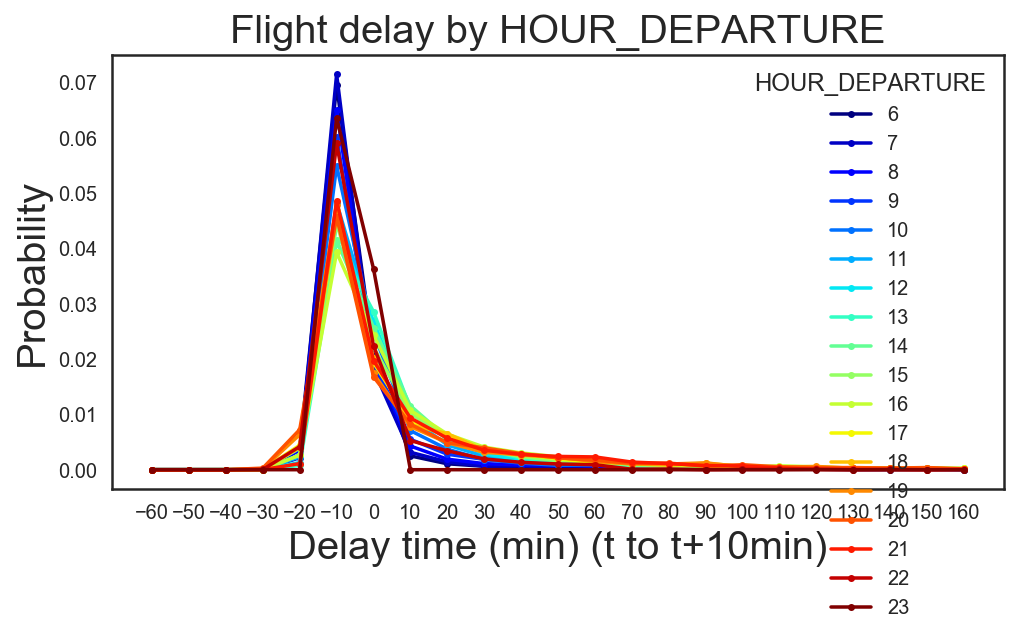

In [16]:
analysis_fn = util.relation_histogram
analysis_kwargs = {'bin_edges':np.arange(-60,180,10)}

plt.figure(figsize=(8,4))
y_by_x_hist, bin_edges = util.relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel('Delay time (min) (t to t+10min)',size=20)
plt.ylabel('Probability', size=20)
plt.title('Flight delay by '+key_feature,size=20)
plt.legend(title=key_feature)

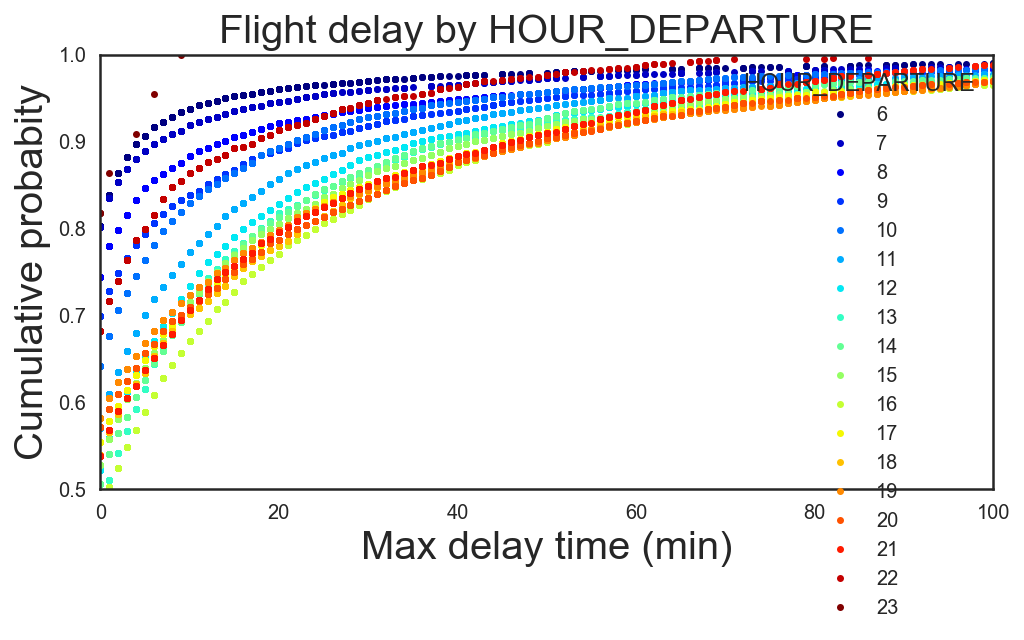

In [17]:
analysis_fn = util.relation_ecdf
analysis_kwargs = {}

plt.figure(figsize=(8,4))
y_by_x_cdf = util.relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlim((0,100))
plt.ylim((.5,1))
plt.xlabel('Max delay time (min)',size=20)
plt.ylabel('Cumulative probabity', size=20)
plt.legend(fontsize=10,title=key_feature)
plt.title('Flight delay by '+key_feature,size=20)

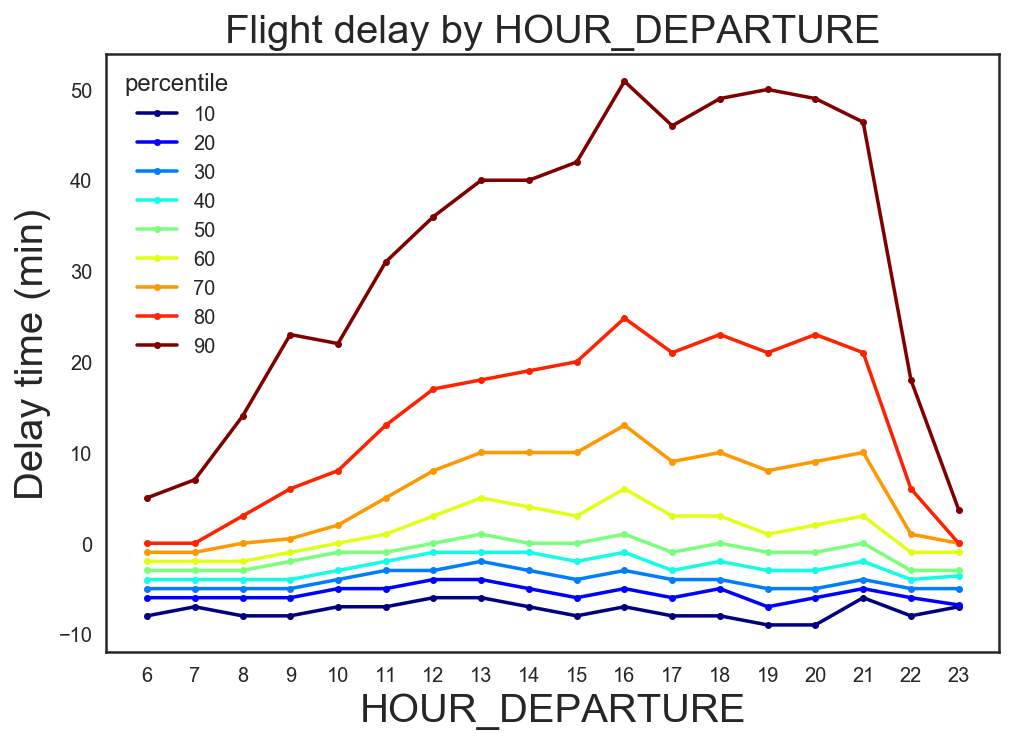

In [18]:
analysis_fn = util.relation_quantiles
analysis_kwargs = {'all_quantiles': np.arange(10,100,10)}
y_by_x_quantile, all_quantiles = util.relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel(key_feature,size=20)
plt.ylabel('Delay time (min)', size=20)
plt.legend(fontsize=10, title='percentile')
plt.title('Flight delay by '+key_feature,size=20)

(-0.5, 20.5)

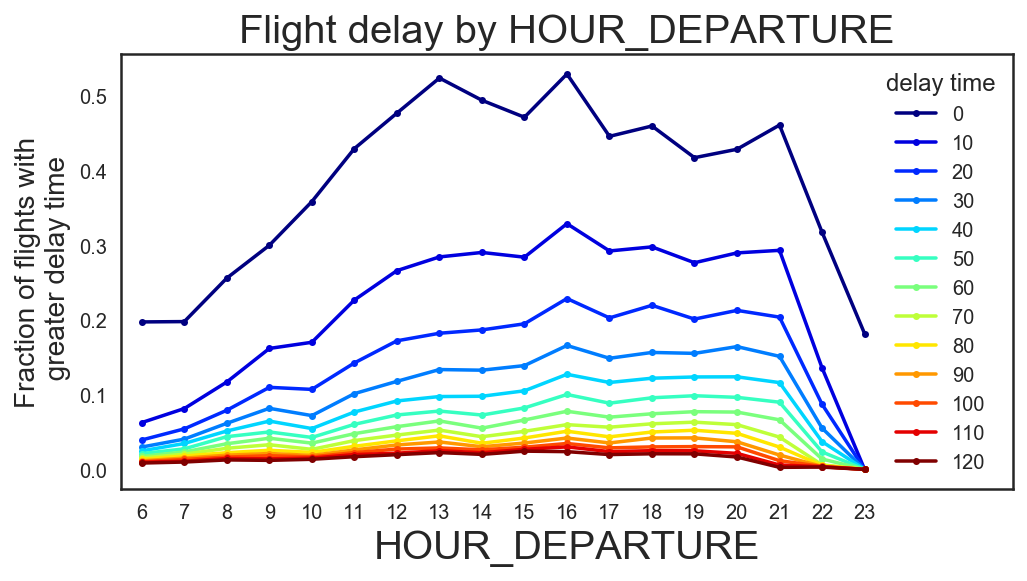

In [22]:
analysis_fn = util.relation_exceed
analysis_kwargs = {'all_min': np.arange(0,130,10)}
plt.figure(figsize=(8,4))
y_by_x_min , all_min = util.relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel(key_feature,size=20)
plt.ylabel('Fraction of flights with\n greater delay time', size=14)
plt.legend(fontsize=10, title='delay time')
plt.title('Flight delay by '+key_feature,size=20)
plt.xlim((-.5,20.5))

(-0.5, 20.5)

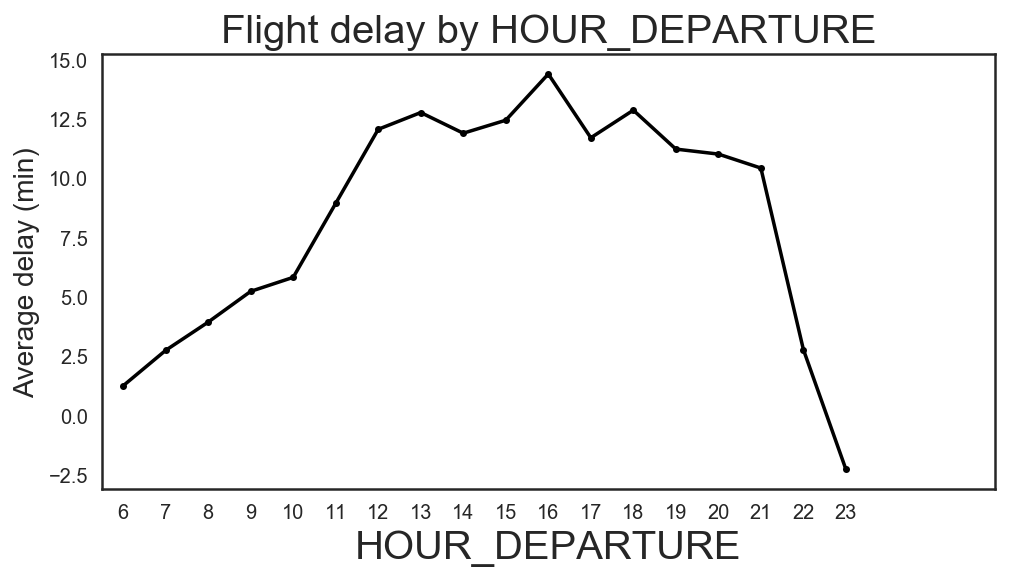

In [23]:
analysis_fn = util.relation_mean
analysis_kwargs = {}
plt.figure(figsize=(8,4))
y_by_x_mean = util.relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel(key_feature,size=20)
plt.ylabel('Average delay (min)', size=14)
plt.title('Flight delay by '+key_feature,size=20)
plt.xlim((-.5,20.5))